# Pipeline:


### -Lectura del Dataset original. [path dataset Original]

### -Agregar Features [numero de features mas representativos a incluir]
### -Agregar Clasificacion [valores para separar]

# Notebook donde se compara la mejor ejecucion con valores balanceados y no balanceados. Revisar graficas finales

In [2]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import os, glob

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
#plots
import seaborn as sns

from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy, resample_apply
from backtesting.test import SMA
from backtesting import Backtest
#plots
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd 
import math as m
import os, glob

Loading BokehJS ...

In [3]:
MODEL_NAME = "XGBoost_6"
FRECUENCIA = "4H"
INDEX_TO_READ = 5
LIMITE_IZQ = [-.002] #-0.0025, -.002, -.0018] #[-.002]#[-0.0029, -0.0025, -.002]
LIMITE_DER = [.0025] # 0.0025, .002, .0018] #[.0025]#[0.0029, 0.0025, .002]

BALANCED = True
TARGET_NAME = "Class"
PROFUNDIDAD = [0,4,6] #[0,1,2,3,4,5,6,7,8,9,10] #[1,2] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

VAL_PCT = [.25]#[.2, .25]
TEST_PCT = [.2, .19, .18, .17, .16, .15, .14, .13, .12, .11, .1]#[.2, .15]


CASH = 1000
COMMISSION = 0.0001

In [4]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados-regression/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   R-EURUSD_FULL_1D_144F.csv
1   R-EURUSD_FULL_1D_44F.csv
2   R-EURUSD_FULL_1D_69F.csv
3   R-EURUSD_FULL_1H_44F.csv
4   R-EURUSD_FULL_1H_49F.csv
5   R-EURUSD_FULL_4H_144F.csv


In [5]:
def read_dataset(INDEX_TO_READ):
    if FRECUENCIA =="1D":
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    else:
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    DATASET_FULL = pd.read_csv(filenames[INDEX_TO_READ], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
    #print(DATASET_FULL)
    #print(DATASET_FULL.shape)
    return DATASET_FULL
    
def add_target_column(DATASET_FULL, limite_izq, limite_der):
    DATASET_FULL['Class'] = 0

    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] <= limite_izq, 'Class'] = -1
    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] >= limite_der, 'Class'] = 1

    DATASET_FULL['Class'] = DATASET_FULL['Class'].shift(-1)
    DATASET_FULL['Class'].fillna(0, inplace=True)
    #print(DATASET_FULL['Class'].head(5))
    return DATASET_FULL


def remove_features(data):
    data = data.drop(['Gmt time'], axis = 1)
    data = data.drop(['day_name'], axis = 1)
    data = data.drop(['weekday'], axis = 1)
    data = data.drop(['Open_Bid'], axis = 1)
    data = data.drop(['High_Bid'], axis = 1)
    data = data.drop(['Low_Bid'], axis = 1)
    data = data.drop(['Close_Bid'], axis = 1)
    return data

def get_target_vector(data):
    labels = data['Class'].values
    data = data.drop(columns=['Class'])
    return data, labels

def get_2Dimension(df, PROFUNDIDAD):
    new_df = pd.DataFrame()
    for i in range(PROFUNDIDAD):
        for j in range (df.shape[1]):
            new_col_name = df.columns[j] + '_' + str(i+1)
            new_df[new_col_name] = df.iloc[i+1:,j]
            new_df.fillna(method='backfill', inplace=True)
    #print(new_df.columns)
    df = pd.concat([df, new_df], axis=1, sort=False)
    df.fillna(method='backfill', inplace=True)
    return df

def split_in_3(data, y_vector, val_pct, test_pct):
    total = data.shape[0]
    #print('Total: ', total)

    s1 = test_pct + val_pct
    #print('Sum of %s:',s1)
    f1 = int(total * s1)
    #print('count of Val and Test:',f1)
    end_train = total - f1
    #print('end of train: ', end_train)

    count_val= int(total * val_pct)
    #print('count val: ',count_val)

    count_test= int(total * test_pct)
    #print('count test: ',count_test)

    end_val = end_train + count_val
    #print('end_val', end_val)

    x_train = data.iloc[:end_train]
    x_val = data.iloc[end_train: end_val]
    x_val.reset_index(drop=True, inplace=True)
    x_test = data.iloc[end_val:]
    x_test.reset_index(drop=True, inplace=True)

    #print("x_train.shape: ",x_train.shape)
    #print("x_val.shape: ", x_val.shape)
    #print("x_test.shape: ", x_test.shape)

    y_train = y_vector[:end_train]
    y_val = y_vector[end_train: end_val]
    y_test = y_vector[end_val:]

    #print("y_train.shape: ", y_train.shape)
    #print("y_val.shape: ", y_val.shape)
    #print("y_test.shape: ", y_test.shape)

    
    return x_train, x_val, x_test, y_train, y_val, y_test

def get_train_resampling(x_train, y_train):
    target = pd.DataFrame(y_train, columns = ["target"])
    x_train_target  = pd.concat([x_train, target], axis=1, sort=False)
    x_train_target['target'].value_counts()

    match_majority = x_train_target['target'].value_counts()[0]
    match_majority

    # resample for sell
    df_majority_sell = x_train_target[x_train_target.target != -1]
    df_minority_sell = x_train_target[x_train_target.target == -1]
    df_minority_sell_upsampled = resample(df_minority_sell, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled_sell = pd.concat([df_majority_sell, df_minority_sell_upsampled])
    df_upsampled_sell['target'].value_counts()


    #resample for buy
    df_majority_buy = df_upsampled_sell[df_upsampled_sell.target != 1]
    df_minority_buy = df_upsampled_sell[df_upsampled_sell.target == 1]
    df_minority_buy_upsampled = resample(df_minority_buy, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled  = pd.concat([df_majority_buy, df_minority_buy_upsampled])
    df_upsampled['target'].value_counts()
    labels = df_upsampled['target'].values
    df_upsampled = df_upsampled.drop(['target'], axis = 1)
    return df_upsampled, labels


def train_xgboost_model(x_train, y_train):
    # Train the model, this will take a few minutes to run
    bst = xgb.XGBClassifier(
        objective='reg:logistic'
    )

    bst.fit(x_train, y_train)
    return bst

def get_predictions(model, x_subset):
    predictions = model.predict(x_subset)
    return predictions

def get_acc(predicted, y_subset):
    acc = accuracy_score(y_subset, predicted.round())
    #print(acc, '\n')
    return acc

def print_confision_matrix(y_test, y_pred):
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred.round())
    cm = cm / cm.astype(np.float).sum(axis=1)
    print(cm)
    
def get_dataset_with_pred(dataset_x, vec_y, vec_y_pred):
    y_df = pd.DataFrame({'Real_Class': vec_y})
    y_pred_df = pd.DataFrame({'Predicted_Class': vec_y_pred})
    #print('y_df ',y_df.shape)
    #print('y_pred_df ',y_pred_df.shape)
    dataset_x_vec_y = pd.concat([dataset_x,y_df], axis=1, sort=False)
    #print('dataset_x_vec_y ',dataset_x_vec_y.shape)
    dataset_x_vec_y_pred = pd.concat([dataset_x_vec_y,y_pred_df], axis=1, sort=False)
    #print('x_test ', dataset_x_vec_y_pred.shape)
    return dataset_x_vec_y_pred

def get_filepath_results():
    filename = 'BackTesting_Results.csv'
    #print(filename)
    pwd = os.getcwd()
    path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/')
    filename_path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/' + filename)
    #print(filename_path_backstesting)
    return filename_path_backstesting

def backtest(full_test):
    STRATEGY_NAME = limits_Pred
    bt = Backtest(full_test, STRATEGY_NAME, cash=CASH, commission=COMMISSION)#trade_on_close=False
    bt.run()
    return bt._results

In [6]:
class limits_Pred(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Predicted_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [7]:
class limits_Real(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Real_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [8]:
def pipeline_one(LIMITE_IZQ_one, LIMITE_DER_one, VAL_PCT_one, TEST_PCT_one,  PROFUNDIDAD_one):
    Dataset =  read_dataset(INDEX_TO_READ)
    Dataset_with_target = add_target_column(Dataset, LIMITE_IZQ_one, LIMITE_DER_one)
    Dataset_remove_features = remove_features(Dataset_with_target)

    SIZE = Dataset_remove_features.shape[0]
    NUM_FEATURES = Dataset_remove_features.shape[1]

    Data_without_target, Data_target = get_target_vector(Dataset_remove_features)

    Dataset_in_2d =  get_2Dimension(Data_without_target, PROFUNDIDAD_one)

    x_train, x_val, x_test, y_train, y_val, y_test = split_in_3(Dataset_in_2d, Data_target, VAL_PCT_one, TEST_PCT_one)
    #Resample Balance 
    if (BALANCED):
        x_train, y_train = get_train_resampling(x_train, y_train)
    
    #Shuffle x_train 
    
    model = train_xgboost_model(x_train, y_train)


    test_predictions =  get_predictions(model, x_test)
    ACC_TEST = get_acc (test_predictions, y_test)
    #print_confision_matrix(y_test, test_predictions)

    val_predictions =  get_predictions(model, x_val)
    ACC_VAL = get_acc (val_predictions, y_val)
    #print_confision_matrix(y_val, val_predictions)

    full_test =  get_dataset_with_pred(x_test, y_test, test_predictions)
    full_val =  get_dataset_with_pred(x_val, y_val, val_predictions)
    filepath_results = get_filepath_results()
    bt_pred = backtest(full_test)

    data_results = {'Model_Name':[MODEL_NAME], 
                    'FRECUENCIA':[FRECUENCIA], 
                    'LIMITE_IZQ':[LIMITE_IZQ_one], 
                    'LIMITE_DER':[LIMITE_DER_one],
                    'PROFUNDIDAD':[PROFUNDIDAD_one],
                    'BALANCED':[BALANCED],
                    'VAL_PCT':[VAL_PCT_one], 
                    'TEST_PCT':[TEST_PCT_one], 
                    'ACC_TEST':[ACC_TEST],
                    'ACC_VAL':[ACC_VAL],
                    'Duration':[bt_pred['Duration']],
                    'Exposure':[bt_pred['Exposure [%]']],
                    'Buy & Hold Return [%]':[bt_pred['Buy & Hold Return [%]']],
                    '_strategy':[bt_pred['_strategy']],                
                    'Pred_Equity_Final_$':[bt_pred['Equity Final [$]']], 
                    'Pred_Equity_Peak_$':[bt_pred['Equity Peak [$]']], 
                    'Pred_Return_%':[bt_pred['Return [%]']], 
                    'Pred_#_Trades':[bt_pred['# Trades']], 
                    'Pred_Win_Rate':[bt_pred['Win Rate [%]']],
                    'Commission':[COMMISSION],
                    'Cash':[CASH]}
    Results = pd.DataFrame(data_results)
    print('Equity Final [$]: ',bt_pred['Equity Final [$]'])

    Results_loaded = pd.read_csv(filepath_results, header=0)
    Results_loaded = Results_loaded.append(Results,ignore_index=True)

    Results_loaded.to_csv(filepath_results, header=True, index=False)
    return Results_loaded

In [9]:
for k in range(len(LIMITE_IZQ)):
    lim_izq = LIMITE_IZQ[k]
    print('LIMITE_IZQ: ', lim_izq)
    for o in range(len(LIMITE_DER)):
        lim_der = LIMITE_DER[o]
        print('   LIMITE_DER: ', lim_der)
        for i in range(len(PROFUNDIDAD)):
            prof_one = PROFUNDIDAD[i]
            print('      PROFUNDIDAD: ', prof_one)
            for j in range(len(VAL_PCT)):
                val_pct_one = VAL_PCT[j]
                print('         VAL_PCT: ', val_pct_one)
                for jj in range(len(TEST_PCT)):
                    test_pct_one = TEST_PCT[jj]
                    print('            TEST_PCT: ', test_pct_one)
                    pipeline_one(lim_izq, lim_der, val_pct_one, test_pct_one, prof_one)

LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  917.7071746665271
            TEST_PCT:  0.19
Equity Final [$]:  930.5517430529649
            TEST_PCT:  0.18
Equity Final [$]:  977.9823286432528
            TEST_PCT:  0.17
Equity Final [$]:  997.7048781060522
            TEST_PCT:  0.16
Equity Final [$]:  1114.2769335735306
            TEST_PCT:  0.15
Equity Final [$]:  942.5857621163093
            TEST_PCT:  0.14
Equity Final [$]:  1013.2280393489881
            TEST_PCT:  0.13
Equity Final [$]:  969.3318499047291
            TEST_PCT:  0.12
Equity Final [$]:  965.873862724691
            TEST_PCT:  0.11
Equity Final [$]:  980.7070623171466
            TEST_PCT:  0.1
Equity Final [$]:  1011.4088577869077
      PROFUNDIDAD:  4
         VAL_PCT:  0.25
            TEST_PCT:  0.2
Equity Final [$]:  1049.9063476695276
            TEST_PCT:  0.19
Equity Final [$]:  1003.0492587377275
            TEST_PC

In [10]:
filepath_results = get_filepath_results()
Results_loaded = pd.read_csv(filepath_results, header=0)
this_model = Results_loaded.loc[Results_loaded['Model_Name'] == MODEL_NAME]
this_model

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,VAL_PCT,TEST_PCT,ACC_TEST,ACC_VAL,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
201,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.20,0.640498,0.623433,...,99.358248,4.583859,limits_Pred,917.707175,1061.849644,-8.229283,265.0,52.830189,0.0001,1000
202,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.19,0.835320,0.777895,...,78.899265,4.666579,limits_Pred,930.551743,1069.931513,-6.944826,8.0,37.500000,0.0001,1000
203,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.18,0.616691,0.661483,...,78.628356,0.835898,limits_Pred,977.982329,1112.064814,-2.201767,28.0,42.857143,0.0001,1000
204,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.17,0.804396,0.769893,...,98.290029,5.996668,limits_Pred,997.704878,1046.441327,-0.229512,72.0,55.555556,0.0001,1000
205,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.16,0.753480,0.739695,...,99.339311,6.029250,limits_Pred,1114.276934,1194.776080,11.427693,203.0,56.157635,0.0001,1000
206,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.15,0.834675,0.795561,...,0.000000,5.646380,limits_Pred,942.585762,1063.328117,-5.741424,0.0,NaN,0.0001,1000
207,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.14,0.842545,0.785747,...,81.175836,9.192801,limits_Pred,1013.228039,1033.242383,1.322804,28.0,50.000000,0.0001,1000
208,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.13,0.694251,0.704213,...,96.572756,10.088166,limits_Pred,969.331850,1006.759204,-3.066815,84.0,51.190476,0.0001,1000
209,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.12,0.857817,0.800393,...,67.621145,5.564618,limits_Pred,965.873863,1010.442584,-3.412614,8.0,37.500000,0.0001,1000
210,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.11,0.861016,0.792692,...,53.793340,4.157613,limits_Pred,980.707062,1012.960599,-1.929294,6.0,50.000000,0.0001,1000


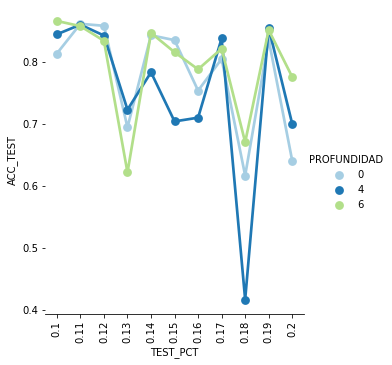

In [17]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="TEST_PCT", y="ACC_TEST", hue="PROFUNDIDAD", #col="ACC_VAL",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

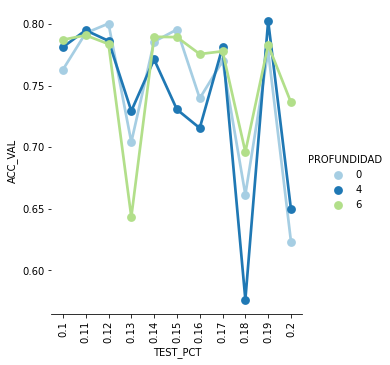

In [18]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="TEST_PCT", y="ACC_VAL", hue="PROFUNDIDAD", #col="ACC_VAL",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

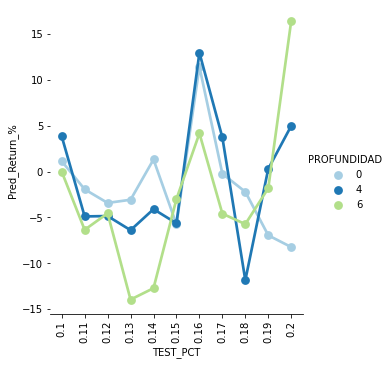

In [19]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="TEST_PCT", y="Pred_Return_%", hue="PROFUNDIDAD", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

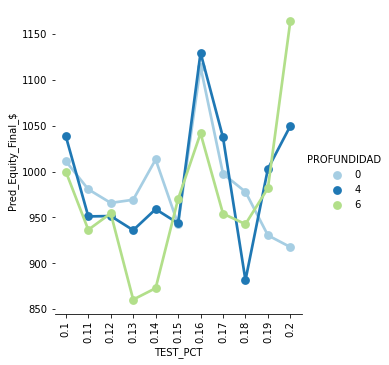

In [20]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="TEST_PCT", y="Pred_Equity_Final_$", hue="PROFUNDIDAD", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.despine(left=True)

## Aqui se observa como con un subset de validacion de .25 PCT es mejor que con uno de .20 pct. 

## Ademas se observa que los resultados son mejores si se usa una profundidad de 1 a 10, en comparacion de profundidades mayores a 10-24

In [21]:
winners = this_model.loc[this_model['Pred_Return_%'] >= 0]
winners

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,VAL_PCT,TEST_PCT,ACC_TEST,ACC_VAL,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
205,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.16,0.753480,0.739695,...,99.339311,6.029250,limits_Pred,1114.276934,1194.776080,11.427693,203.0,56.157635,0.0001,1000
207,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.14,0.842545,0.785747,...,81.175836,9.192801,limits_Pred,1013.228039,1033.242383,1.322804,28.0,50.000000,0.0001,1000
211,XGBoost_6,4H,-0.002,0.0025,0,True,0.25,0.10,0.813137,0.762947,...,96.374622,3.260955,limits_Pred,1011.408858,1013.192230,1.140886,20.0,45.000000,0.0001,1000
212,XGBoost_6,4H,-0.002,0.0025,4,True,0.25,0.20,0.699755,0.649555,...,99.528124,4.583859,limits_Pred,1049.906348,1080.020524,4.990635,329.0,48.632219,0.0001,1000
213,XGBoost_6,4H,-0.002,0.0025,4,True,0.25,0.19,0.854589,0.802506,...,0.000000,4.666579,limits_Pred,1003.049259,1033.458910,0.304926,0.0,NaN,0.0001,1000
215,XGBoost_6,4H,-0.002,0.0025,4,True,0.25,0.17,0.837478,0.781217,...,98.556518,5.996668,limits_Pred,1037.301070,1063.934530,3.730107,35.0,62.857143,0.0001,1000
216,XGBoost_6,4H,-0.002,0.0025,4,True,0.25,0.16,0.709837,0.715537,...,99.504483,6.029250,limits_Pred,1129.648819,1138.331085,12.964882,312.0,55.448718,0.0001,1000
222,XGBoost_6,4H,-0.002,0.0025,4,True,0.25,0.10,0.844092,0.781217,...,96.148036,3.260955,limits_Pred,1038.523587,1040.354770,3.852359,12.0,41.666667,0.0001,1000
223,XGBoost_6,4H,-0.002,0.0025,6,True,0.25,0.20,0.775429,0.736373,...,99.358248,4.583859,limits_Pred,1164.303951,1195.267662,16.430395,168.0,59.523810,0.0001,1000
227,XGBoost_6,4H,-0.002,0.0025,6,True,0.25,0.16,0.787686,0.775630,...,97.144880,6.029250,limits_Pred,1041.753337,1156.906731,4.175334,133.0,51.127820,0.0001,1000


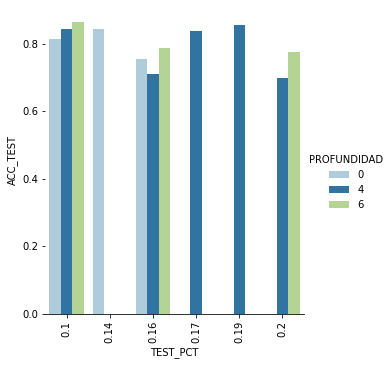

In [23]:


# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="TEST_PCT", y="ACC_TEST", hue="PROFUNDIDAD", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="bar", data=winners)
g.set_xticklabels(rotation=90)
g.despine(left=True)